# Классификация


## 1. Разминка: что за задача?

Используем классический набор `Breast Cancer` из `sklearn`. Каждая строка — биопсия опухоли молочной железы:
- выделено 30 числовых признаков (радиус, текстура, периметр, симметрия и т.д.).
- таргет `target`: `0` — доброкачественная, `1` — злокачественная опухоль.
- признаки уже посчитаны из медицинских снимков, поэтому сразу работаем с числовой матрицей.

Цель — по измерениям понять, злокачественная ли опухоль.


In [1]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

data_raw = load_breast_cancer()
X = pd.DataFrame(data_raw.data, columns=data_raw.feature_names)
y = pd.Series(data_raw.target, name='target')

X.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


<details>
<summary><strong>Вопрос:</strong> почему не делаем очистку/фичи заново?</summary>
<strong>Ответ:</strong> датасет уже чистый и отмасштабированный — сосредотачиваемся на классификации, как и договаривались.
</details>


## 2. Что такое классификация и где тут логистическая регрессия?

- **Классификация** — предсказание метки класса по признакам.
- Бывают варианты:
  - **Бинарная** (два класса: как у нас — злокачественная/доброкачественная).
  - **Мультиклассовая** (несколько классов, например породы цветов).
  - **Мульти-лейбловая** (несколько независимых меток, например жанры песни).
- Логистическая регрессия оценивает логиты (log-odds) и преобразует их в вероятность через сигмоиду:
  $$ \hat{p}(y=1|x) = \sigma(w^\top x + b) = \frac{1}{1 + e^{-(w^\top x + b)}} $$
- Граница решения там, где вероятность 0.5 (логит = 0). Меняем порог — сдвигаем границу.
- Обучение — минимизируем логистическую функцию потерь (кросс-энтропию), обновляя веса, чтобы реальные объекты получали высокую вероятность своего класса.

Практика: разделим данные и посмотрим базовую модель.


<details>
<summary><strong>Вопрос:</strong> зачем знать тип классификации?</summary>
<strong>Ответ:</strong> разные типы требуют разных алгоритмов и метрик: мультикласс — это одна стратегия (один против всех), мульти-лейбл — уже несколько независимых классификаторов или sigmoid на каждом таргете.
</details>


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape


((455, 30), (114, 30))

<details>
<summary><strong>Вопрос:</strong> зачем делим со стратификацией?</summary>
<strong>Ответ:</strong> чтобы доля классов в train/test осталась одинаковой — иначе метрики будут гулять.
</details>


## 3. Базовая логистическая регрессия в `sklearn`

1. Масштабируем признаки (логистическая чувствительна к масштабу).
2. Строим `LogisticRegression`.
3. Смотрим основные метрики.

Код держим компактным: используем пайплайн.


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

baseline_model = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=500, random_state=42))
])
baseline_model.fit(X_train, y_train)

y_pred = baseline_model.predict(X_test)
y_proba = baseline_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

acc, f1, roc_auc


(0.9824561403508771, 0.9861111111111112, 0.9953703703703703)

<details>
<summary><strong>Вопрос:</strong> почему сразу считаем несколько метрик?</summary>
<strong>Ответ:</strong> Accuracy может быть высокой даже при плохой работе на редком классе, поэтому добавляем F1 и ROC-AUC.
</details>


## 4. Разбираемся с метриками на практике

- **Accuracy** — доля верно классифицированных объектов. Хорошо, когда классы сбалансированы.
- **Precision** — среди предсказанных "злокачественных" сколько действительно таких (важно, если боимся ложной тревоги).
- **Recall** — сколько реальных злокачественных мы нашли (важно, если нельзя упустить болезнь).
- **F1** — гармоническое среднее precision и recall, когда хотим баланс.
- **ROC-кривая** строится по парам (FPR, TPR) при разных порогах: 
  - TPR (recall) = TP / (TP + FN)
  - FPR = FP / (FP + TN)
- **ROC-AUC** — площадь под кривой. Чем ближе к 1, тем чаще модель ставит истинные положительные выше отрицательных. 0.5 — случайные угадайки.
- Зачем ROC-AUC: он не зависит от конкретного порога и показывает, насколько хорошо модель ранжирует классы при любом сдвиге.

Посмотрим confusion matrix и ROC-кривую — визуально проще понять ошибки и компромисс чувствительность/специфичность.


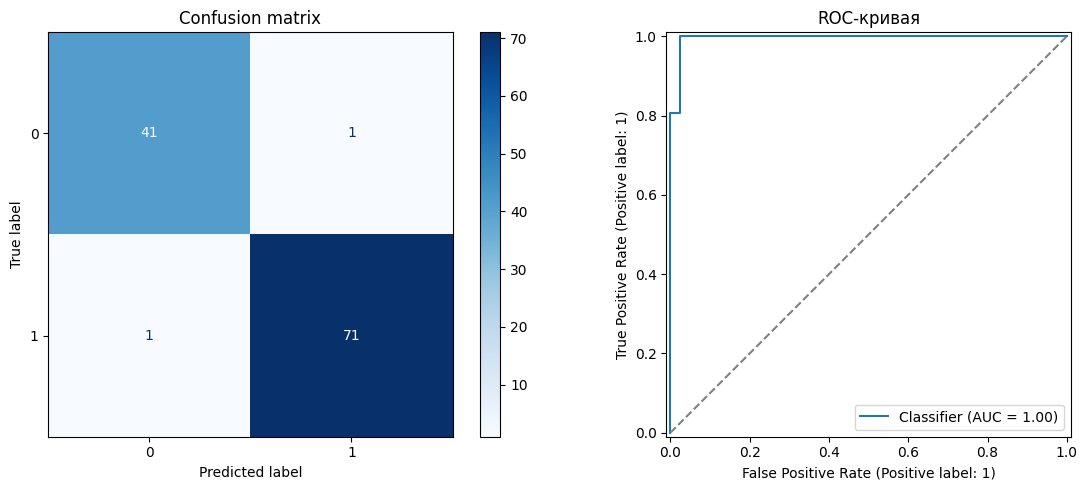

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=axes[0], cmap="Blues")
axes[0].set_title("Confusion matrix")

RocCurveDisplay.from_predictions(y_test, y_proba, ax=axes[1])
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[1].set_title("ROC-кривая")
plt.tight_layout()
plt.show()


<details>
<summary><strong>Вопрос:</strong> что показывает ROC-AUC на практике?</summary>
<strong>Ответ:</strong> это шанс, что модель поставит более высокий скор объекту класса 1, чем объекту класса 0. Высокий ROC-AUC значит, что при переборе порогов класс 1 в среднем оказывается выше.
</details>


## 5. Настраиваем гиперпараметры: `RandomizedSearchCV`

- У логистической регрессии есть гиперпараметр `C` (обратная сила регуляризации) и вид штрафа.
- **GridSearchCV**: задаём сетку значений (например `C = [0.1, 1, 10]`, `penalty = ['l1','l2']`) и перебираем каждую комбинацию. Гарантия найти лучший вариант в сетке, но цена — экспоненциальный рост времени.
- **RandomizedSearchCV**: задаём распределения (у нас логарифмически spaced `C`) и число итераций. Получаем хороший результат быстрее, особенно когда диапазон широк и точные значения неизвестны.
- Мы хотим покрыть большой диапазон `C`, поэтому используем случайный поиск с метрикой `F1` и перекрёстной проверкой.


In [5]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_distributions = {
    "logreg__C": np.logspace(-3, 2, 30),
    "logreg__penalty": ["l1", "l2"],
    "logreg__solver": ["liblinear", "saga"],
}

search = RandomizedSearchCV(
    baseline_model,
    param_distributions=param_distributions,
    n_iter=20,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    random_state=42,
)
search.fit(X_train, y_train)

search.best_params_, search.best_score_


/home/mariyasoloveva/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mariyasoloveva/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mariyasoloveva/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mariyasoloveva/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/mariyasoloveva/.pyenv/versions/3.10.14/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means

({'logreg__solver': 'liblinear',
  'logreg__penalty': 'l2',
  'logreg__C': np.float64(0.38566204211634725)},
 np.float64(0.9843438445612358))

<details>
<summary><strong>Вопрос:</strong> когда стоит выбрать `GridSearchCV`, а когда `RandomizedSearchCV`?</summary>
<strong>Ответ:</strong> Grid-поиск хорош, если гиперпараметров мало и есть узкая сетка значений. Randomized-поиск берём, когда диапазон огромный или параметры непрерывные — можно быстро опробовать много комбинаций и сэкономить время.
</details>


## 6. Оцениваем лучшую модель

Берём найденный пайплайн и сравниваем с базовой моделью по тем же метрикам.


In [6]:
best_model = search.best_estimator_

y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)[:, 1]

metrics = {
    "Model": ["Baseline", "Tuned"],
    "Accuracy": [acc, accuracy_score(y_test, y_pred_best)],
    "F1": [f1, f1_score(y_test, y_pred_best)],
    "ROC-AUC": [roc_auc, roc_auc_score(y_test, y_proba_best)],
}

pd.DataFrame(metrics)


,Model,Accuracy,F1,ROC-AUC
0,Baseline,0.982456,0.986111,0.995370
1,Tuned,0.982456,0.986111,0.996362


### Как выглядит результат классификации?

Сведём предсказания в таблицу: вероятность класса 1, финальное решение и настоящий ответ.


In [8]:
pd.DataFrame({
    "prob_class1": y_proba_best.round(3),
    "predicted": y_pred_best,
    "true": y_test.reset_index(drop=True)
}).head(10)


,prob_class1,predicted,true
0,0.000,0,0
1,1.000,1,1
2,0.014,0,0
3,0.522,1,1
4,0.000,0,0
5,0.985,1,1
6,1.000,1,1
7,0.000,0,0
8,0.000,0,0
9,0.000,0,0


<details>
<summary><strong>Вопрос:</strong> почему вероятность и предсказание не всегда совпадают?</summary>
<strong>Ответ:</strong> потому что порог срабатывания может быть любым: вероятность 0.48 — это ещё класс 0 при пороге 0.5, но станет 1, если снизим порог.
</details>


<details>
<summary><strong>Вопрос:</strong> всегда ли тюнинг даёт выигрыш?</summary>
<strong>Ответ:</strong> не обязательно. Но даже если прирост небольшой, мы уверяемся, что модель близка к оптимуму на заданных признаках.
</details>


## 7. Выбор порога: обмениваем точность на полноту

По умолчанию `predict` использует порог 0.5. Посмотрим, что будет при другом пороге и как меняется F1/precision/recall.


In [7]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

thresholds = np.linspace(0.1, 0.9, 9)
rows = []
for thr in thresholds:
    y_thr = (y_proba_best >= thr).astype(int)
    rows.append({
        "threshold": thr,
        "precision": precision_score(y_test, y_thr),
        "recall": recall_score(y_test, y_thr),
        "f1": f1_score(y_test, y_thr),
    })

pd.DataFrame(rows)


,threshold,precision,recall,f1
0,0.1,0.935065,1.000000,0.966443
1,0.2,0.947368,1.000000,0.972973
2,0.3,0.972973,1.000000,0.986301
3,0.4,0.972603,0.986111,0.979310
4,0.5,0.986111,0.986111,0.986111
5,0.6,0.985507,0.944444,0.964539
6,0.7,0.985075,0.916667,0.949640
7,0.8,0.984615,0.888889,0.934307
8,0.9,1.000000,0.750000,0.857143


<details>
<summary><strong>Вопрос:</strong> как выбрать порог?</summary>
<strong>Ответ:</strong> исходя из бизнес-задачи. Если важнее поймать максимум злокачественных случаев — снижаем порог, принимаем больше ложных срабатываний.
</details>


## 8. Чек-лист, что запомнить

- Классификация бывает бинарной, мультиклассовой и мульти-лейбловой.
- Логистическая регрессия прогнозирует вероятность через сигмоиду и решает задачу кросс-энтропии.
- Метрики смотрим комплексно: Accuracy, Precision/Recall, F1, ROC-AUC, confusion matrix.
- ROC-AUC показывает, насколько хорошо модель ранжирует положительные объекты выше отрицательных.
- `Pipeline` + `RandomizedSearchCV`/`GridSearchCV` помогают быстро тестировать гиперпараметры.
- Порог можно менять под бизнес-требования: ним управляем балансом ложных срабатываний и пропусков.
